<a href="https://colab.research.google.com/github/afarley9/perovskites/blob/main/examples/CNN_regression_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and CNN example for Log(Ld80) prediction from just the PL images.
## **Note that the training data is available only to the members to the team. So, only the team members can access the master index csv file.**

This is how Google colab's `mount` is being used to read data directly from the drive without downloading or uploading. By directly routing data to the Colab's virtual machine, we will be able stream line it directly into the neural network being built by other team folks.



In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import json
!pip install scikit-learn>=0.24

# Mount the drive and clone the github repo
drive.mount('/content/drive/')

Mounted at /content/drive/


This is how the github [repository](https://github.com/afarley9/perovskites) is being cloned into the virtual machine and loaded.

In [ ]:
!git clone https://github.com/afarley9/perovskites.git

# Import modules from the github repo
sys.path.append("/content/perovskites/perovskites")
sys.path.append("/content/perovskites")
import utils.image_processing as impr
import utils.image_loader as loader
import utils.miscellaneous as misc
import cnn
import regression_visualization as reg_vis

Cloning into 'perovskites'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 1132 (delta 247), reused 208 (delta 115), pack-reused 782
Receiving objects: 100% (1132/1132), 21.97 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (699/699), done.


The `settings.json` in the perovskites package has all the relevant settings related to the data files and their paths, the model parameters etc, which can be changed by the user and this affects all the models built inside the package.

In [ ]:
with open('/content/perovskites/perovskites/settings.json', 'r') as file:
    model_info = json.load(file)

print(json.dumps(model_info, indent=4))

{
    "target_image_size_um": 50,
    "target_image_size_pix": 32,
    "number_of_clusters": 10,
    "reduced_pca_dims": 10,
    "y_col": "Ld80",
    "FOV_col": "camera_FOV",
    "extract_channel": "true",
    "shared_drive_path": "/content/drive/Shareddrives/Perovskites_DIRECT",
    "data_info": {
        "local_data_folder": "data",
        "pickle_filename": "PL_data.pickle",
        "data_df_filename": "features_intact_filtered.csv",
        "meta_df_filename": "features_meta_filtered.csv"
    },
    "cnn_model_info": {
        "models_folder_path": "models/cnn_saved_models",
        "history_csv_name": "fit_history.csv",
        "model_json_name": "model.json",
        "model_h5_name": "model.h5",
        "fit_json_name": "fit_info.json"
    },
    "linreg_model_info": {
        "models_folder_path": "models/linreg_saved_models",
        "fit_pickle_name": "fit_pickle.pickle"
    }
}


### **Using `image_loader.PLDataLoader()` class to load the dataset**.
All the data can be loaded from the shared google drive using this single class. It has methods for sampling data (`sample()`) and creaing test-train splits (`test_train_split`). The `image_loader` module contains several less frequently used private functions for use if needed.

In [ ]:
dataset = loader.PLDataLoader()
data_tuple = dataset.train_test_split(test_size=0.2,
                                        random_state=42,
                                        shuffle=True,
                                        return_dfs=True)
X_train = data_tuple[0]
X_test = data_tuple[1]
y_train = data_tuple[2]
y_test = data_tuple[3]
meta_df_train = data_tuple[4]
meta_df_test = data_tuple[5]
data_df_train = data_tuple[6]
data_df_test = data_tuple[7]

# Apply log transform
y_train = np.log(y_train)
y_test = np.log(y_test)
y_label = 'log('+model_info['y_col']+')'

All the paths to the relevant images and the corresponding experimental metadata are stored in a master csv file which lists details of **1,245 individual degradation experiments**. So this study is going to be done on a well-documented and experimentally collected dataset. But, the challenge is that since the data is experimentally collected and is prone to human-induced and other irreducible noise, it is required to undergo an extensive data-cleaning process to get reliable results. As used above, the `PLDataLoader()` can be used to load the data and also make the test-train splits. ***Note that the dataset is currently available only to the team members due to confidentiality of the data as most of it is unpublished***.


### **Creating scope for TPU runtime**
This is the part where we are creating a scope for TPU runtime. We create the model inside the `tpu_strategy.scope` after connecting to a **Google Cloud TPU**.

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.87.197.114:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.87.197.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.197.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### **Training and saving a CNN model**

* ***Input*** : PL image data set with shape (N, 32, 32, 1)
* ***Output*** : log(Ld80) prediction values with shape (N,)

We developed a `CNNPredictor()` class that has an optimized keras-based Convolutional Neural Network (CNN) regression model. Check all the methods in the `CNNPredictor()` class.

In [ ]:
#with tpu_strategy.scope():
model_name = 'training_demo'
demo_model = cnn.CNNPredictor(name=model_name, y_label=y_label)
print(demo_model.__doc__)


    This class the following methods for training, testing, modifying the
    CNN model we have built for perovskites PL images to predict the log(Ld80)
    values. It initializes with the model we have built when called.
    1. summary() : Gives summary of model
    2. get_layers_dict() : Returns the model as dictionary
    3. load_layers_from_dict() : Loads the model from a dictionary
    4. save_model() : Saves the model
    5. load_model() : Loads a model
    6. fit() : Fits the training data
    7. evaluate_error() : Evaluates error at X
    8. predict() : Predicts y at given X
    9. full_analysis() : Does fitting, saving and also visualizations
    


In [ ]:
demo_model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        36896     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          18448     
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                25664     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

Lets train the model from demonstration using just 5 `epochs` and a `batch_size` of 500

In [ ]:
demo_model.fit(X=X_train, y=y_train, epochs=3, batch_size=500,
               validation_split=0.2)

---------------- CNN Training ----------------
|    Size of train set     |              996 |
|      No. of epochs       |                3 |
|        Batch size        |              500 |
|     Feed image shape     | [996, 32, 32, 1] |
----------------------------------------------


Epoch 1/3
2/2 [==============================] - 1s 584ms/step - loss: 91.2768 - val_loss: 62.3324
Epoch 2/3
2/2 [==============================] - 0s 79ms/step - loss: 55.6752 - val_loss: 42.8637
Epoch 3/3
2/2 [==============================] - 0s 87ms/step - loss: 40.9319 - val_loss: 42.7121



You can also save the trained model using the `saved_model` method as shown below. You have an option to overwrite if another model exists with the same name, or provide an alternative name as you wish (see docs for more details). 

In [ ]:
demo_model.save_model(save_to_drive=True,
                      overwrite_existing_model=True)
saved_models_path = model_info['cnn_model_info']['models_folder_path']
saved_models_path = model_info['shared_drive_path'] + '/' + saved_models_path
curr_model_path = saved_models_path + '/' + model_name

print("In cnn_saved_models folder in the shared drive:")
!ls $saved_models_path
print("\nIn '"+ model_name+"' folder in the cnn_saved_models:")
!ls $curr_model_path

In cnn_saved_models folder in the shared drive:
model_logs_batch10   model_logs_batch200  model_logs_batch25  training_demo
model_logs_batch100  model_logs_batch23   model_logs_batch50

In 'training_demo' folder in the cnn_saved_models:
fit_history.csv  fit_info.json	model.h5  model.json


### **Loading a pre-trained CNN model for improving it further**

You can also load a saved CNN model by using it's `model_name`, which is same as the name of its folder, in the `cnn_saved_models`. Note the class variables when `CNNPredictor` is initialized.

In [ ]:
model = cnn.CNNPredictor(name='demo_model_load', y_label=y_label)
print("Current fit epoch status :", model.epochs)
print("Current fit batch_size :", model.batch_size)
print("Current fit history size :", model.history_df.shape)

Current fit epoch status : 0
Current fit batch_size : 0
Current fit history size : (0, 0)


Now, after loading the model `model_logs_batch25` using the `load_model()` method, note the change in the class variable values.

In [ ]:
model.load_model('model_logs_batch25', from_drive=True)
print("Current fit epoch status :", model.epochs)
print("Current fit batch_size :", model.batch_size)
print("Current fit history size :", model.history_df.shape)

# Evaluate error from saved weights
print("\nThe error on the test set obtained")
print("from this previously trained model is:")
print(model.evaluate_error(X_test, y_test), '%')

Current fit epoch status : 500
Current fit batch_size : 25
Current fit history size : (500, 3)

The error on the test set obtained
from this previously trained model is:
28.49675750732422 %


This scoring metric is not available. Returning the
                  mean absolute percentage error instead...

This scoring metric is not available. Returning the
                  mean absolute percentage error instead...



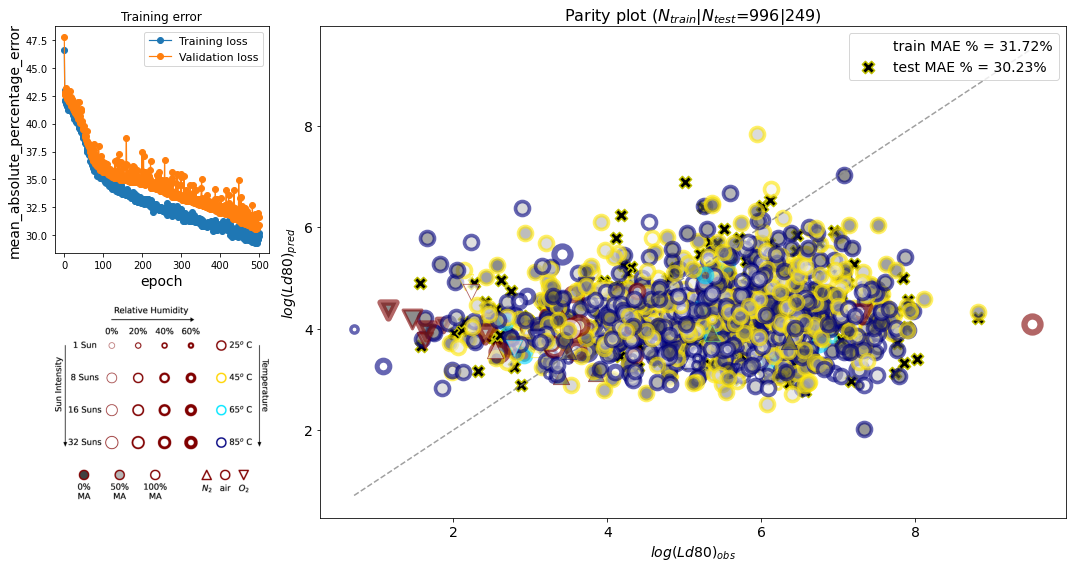

In [ ]:
history_csv = model.history_df
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

# The training and validation error vs epochs plot
model.fit_plot(ax[0, 0],)
ax[0,0].set_title("Training error", fontsize=12)

# The legend plot
model.parity_legend(ax[1, 0], dpi=300)

# Joining two axes to get a big figure for parity plot
gs = ax[0, 1].get_gridspec()
for a in ax[0:, 1:].flatten():
    a.remove()
big_ax = fig.add_subplot(gs[0:, 1:])
model.parity_plot(big_ax, y_train=y_train, y_test=y_test,
                  y_train_pred=y_train_pred, y_test_pred=y_test_pred,
                  data_df_train=data_df_train, data_df_test=data_df_test,
                  )
title_str = 'Parity plot ($N_{train}|N_{test}$'+'={}|{})'.format(len(y_train),
                                                                len(y_test))
big_ax.set_title(title_str, fontsize=16)
fig.tight_layout()


### **Optimizing the batch size for log(Ld80) prediction using CNN**

We have tested the model over different batch sizes to see which one gives the best results. Due to time constraints, we here present the saved models.

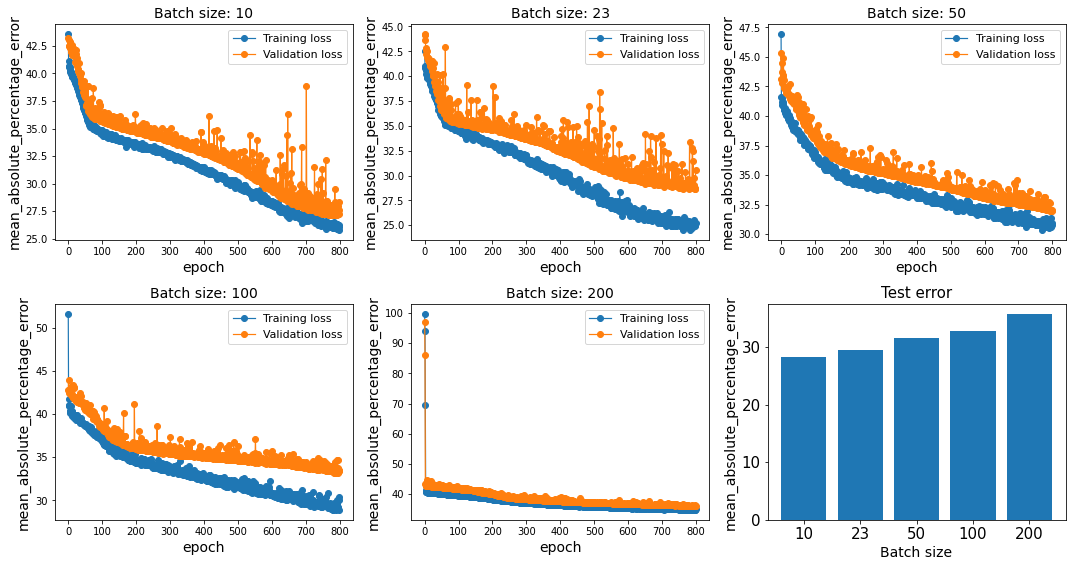

In [ ]:
batch_size_list = [10, 23, 50, 100, 200]
nrows, ncols = misc.best_rowcol_split(len(batch_size_list)+1)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
ax = ax.flatten()
test_errors_list = []

for i, batch_size in enumerate(batch_size_list):
    model_name = 'model_logs_batch'+str(batch_size)
    model = cnn.CNNPredictor(name=model_name, y_label=y_label)
    model.load_model(model_name, from_drive=True)
    model.fit_plot(ax[i])
    ax[i].set_title('Batch size: '+str(batch_size), fontsize=14)
    test_errors_list.append(model.evaluate_error(X_test, y_test))

ax[-1].bar(np.arange(len(batch_size_list)), test_errors_list,
           linewidth=1)
ax[-1].set_title('Test error', fontsize=15)
ax[-1].set_xticks(ticks=np.arange(len(batch_size_list)))
ax[-1].set_xticklabels(batch_size_list)
ax[-1].tick_params(axis='both', labelsize=15)
ax[-1].set_ylabel(model.loss_metric, fontsize=14)
ax[-1].set_xlabel('Batch size', fontsize=14)
fig.tight_layout()